<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/C3VD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install -U --no-cache-dir gdown --pre

In [2]:
import torch 
import sys
import os

pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip -q install fvcore iopath
!pip -q install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html


import pytorch3d as p3d
print(p3d.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 MB 2.8 MB/s eta 0:00:00
0.7.2


In [3]:
!pip -q install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 23.4 MB/s eta 0:00:00


In [4]:
import gdown
import os
import cv2
import matplotlib.pyplot as plt


video_url = 'https://drive.google.com/uc?id=1c_ewx6wts7pJTb3XVWVXEZLbFXDObpdP'
gdown.download(video_url,'SCARED_video.zip',quiet=True) 
if not os.path.exists('/content/SCARED_video/'):
    !unzip -q /content/SCARED_video.zip
!rm SCARED_video.zip

video_pth = '/content/SCARED_video/d{}k{}_rgb.mp4'
frame_pth = '/content/SCARED_frames/d{}k{}_{:06d}.jpg'
if not os.path.isdir('/content/SCARED_frames'):
    !mkdir /content/SCARED_frames


for i in range(1):# 7 in total
  for j in range(4):
      cap = cv2.VideoCapture(video_pth.format(i+1, j+1)) 
      count = 0
      success = True
      while success:
        # cap.set(cv2.CAP_PROP_POS_MSEC, (count * 1800))#1000 ms 1s
        cap.set(cv2.CAP_PROP_POS_FRAMES, (count * 10))#
        success, image = cap.read()
        if success: 
           cv2.imwrite((frame_pth.format(i+1, j+1, count)), image[:1024,:,:], [int(cv2.IMWRITE_JPEG_QUALITY), 100]) #jpg_quality only left image
           count = count + 1
      print(video_pth[-14:-8].format(i+1, j+1), " {}frames  ".format(cap.get(cv2.CAP_PROP_FRAME_COUNT)), count)

# !rm -rf SCARED_video

d1k1  197.0frames   20
d1k2  280.0frames   28
d1k3  471.0frames   48
d1k4  0.0frames   0


#loader

all: 96 train: 76 valid: 20


(<matplotlib.axes._subplots.AxesSubplot at 0x7f49217a8b20>,
 Text(0.5, 1.0, 'd1k1 2'))

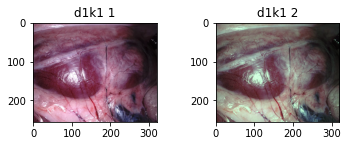

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from glob import glob
from PIL import Image
import numpy as np

# os.chdir('/content')
class MyDataset(Dataset):
    def __init__(self, path_frame=None, transform=None):
        self.path_frame = path_frame
        self.transform = transform
        self.len = len(self.path_frame)

    def __len__(self):
      return len(self.path_frame)   

    def __getitem__(self, i):
        path_frame = self.path_frame[i]
        frame_idx = int(path_frame[-10:-4])
        idx1 = path_frame[-15:-11]+' '+str(frame_idx)
        idx2 = path_frame[-15:-11]+' '+str(frame_idx+1)
        img = Image.open(self.path_frame[i]).convert('RGB')
        try:  
          img_next = Image.open(path_frame.replace(path_frame[-10:-4], "{:06d}".format(frame_idx+1))).convert('RGB')
        except: 
          img_next = img
          idx2 = idx1
        if self.transform:
            img, img_next = self.transform(img), self.transform(img_next)
        return img, img_next, idx1, idx2

class AugmentImage(object):
    def __init__(self, augment_parameters):
        self.gamma_low = augment_parameters[0]  # 0.8
        self.gamma_high = augment_parameters[1]  # 1.2
        self.brightness_low = augment_parameters[2]  # 0.5
        self.brightness_high = augment_parameters[3]  # 2.0
        self.color_low = augment_parameters[4]  # 0.8
        self.color_high = augment_parameters[5]  # 1.2

    def __call__(self, sample):
        p = np.random.uniform(0, 1, 1)
        #if self.do_augmentation:
        if p > 0.5:
            # randomly shift gamma
            random_gamma = np.random.uniform(self.gamma_low, self.gamma_high)
            left_image_aug = sample ** random_gamma

            # randomly shift brightness
            random_brightness = np.random.uniform(self.brightness_low, self.brightness_high)
            left_image_aug = left_image_aug * random_brightness

            # randomly shift color
            random_colors = np.random.uniform(self.color_low, self.color_high, 3)
            for i in range(3):
                left_image_aug[i, :, :] *= random_colors[i]

            # saturate
            left_image_aug = torch.clamp(left_image_aug, 0, 1)

            sample = left_image_aug
        return sample

#(1024, 1280, 3)
transform_test = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),    
])

transform_augment = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),    
    AugmentImage([0.8, 1.2, 0.5, 2.0, 0.8, 1.2]),
])

path_frames_all = glob('SCARED_frames/*.jpg') # 9459 from first 4 datasets
eighty_percent = int(0.8*len(path_frames_all))
path_frames_train = path_frames_all[:eighty_percent]
path_frames_valid = path_frames_all[eighty_percent:]
print('all:', len(path_frames_all),'train:', len(path_frames_train), 'valid:', len(path_frames_valid))

dataset_train = MyDataset(path_frame=path_frames_train, transform=transform_augment)
dataset_valid = MyDataset(path_frame=path_frames_valid, transform=transform_augment)
i = 4
plt.subplot(221), plt.imshow(dataset_train[i][0].permute(1,2,0)), plt.title(dataset_train[i][2])
plt.subplot(222), plt.imshow(dataset_train[i][1].permute(1,2,0)), plt.title(dataset_train[i][3])

In [6]:
import argparse
import sys
import torch

def adjust_learning_rate(optimizer, epoch, learning_rate):
    if epoch >= 30 and epoch < 40:
        lr = learning_rate / 2
    elif epoch >= 40:
        lr = learning_rate / 4
    else:
        lr = learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def seed_everything(seed=42):
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = argparse.ArgumentParser(description=' ')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=4, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=4, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=50, type=int, help='epoch number')
    parser.add_argument('--startEpoch', type=int, default=0, help='epoch that start from')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='mse', help='total gpu')
    parser.add_argument('--applyICP', default=False, help="calculate ICP loss with or without applying masks")
    parser.add_argument('--ICPweight', type=float, default=1/1000, help='weights for ICP in the final loss')
    parser.add_argument('--focal_length', type=float, default=1135, help='mean focal length') 
    parser.add_argument('--baseline', type=float, help='baseline', default=4.2)
    parser.add_argument('--input_height', type=int, help='input height', default=256)
    parser.add_argument('--input_width', type=int, help='input width', default=320)
    parser.add_argument('--full_height', type=int, help='full height', default=1024)
    parser.add_argument('--full_width', type=int, help='full width', default=1280)
    parser.add_argument('--min_depth', type=float, help='minimum depth', default=0.1)
    parser.add_argument('--max_depth', type=float, help='maximum depth', default=100.0)
    parser.add_argument('--n', type=float, help='number of scale', default=4)
    parser.add_argument('--K', type=float, help='average K', default=[[1.18849248e+03, 0.00000000e+00, 6.41449814e+02, 0.00000000e+00], # [[1.03530811e+03 0.00000000e+00 5.96955017e+02]
                                                                          [0.00000000e+00, 1.18849248e+03, 5.20022934e+02, 0.00000000e+00],#  [0.00000000e+00 1.03508765e+03 5.20410034e+02]
                                                                          [0, 0, 1, 0],
                                                                          [0, 0, 0, 1]])
    
    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

#model

In [7]:
import os
import gdown
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch
# from torchmetrics import StructuralSimilarityIndexMeasure

device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.chdir('/content')
if not os.path.isdir('monodepth2'):
    !git clone https://github.com/nianticlabs/monodepth2.git
%cd monodepth2
import networks
from utils import download_model_if_doesnt_exist
from layers import transformation_from_parameters, rot_from_axisangle, get_translation_matrix, Project3D, BackprojectDepth, compute_depth_errors
# from trainer import Trainer

model_name = "mono_640x192"
# model_name = 'mono_1024x320'
# kitti weights path
download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")
pose_encoder_path = os.path.join("models", model_name, "pose_encoder.pth")
pose_decoder_path = os.path.join("models", model_name, "pose.pth")
# MODEL
depth_encoder = networks.ResnetEncoder(18, False).to(device)
depth_decoder = networks.DepthDecoder(num_ch_enc=depth_encoder.num_ch_enc, scales=range(4)).to(device)
pose_encoder = networks.ResnetEncoder(18, "pretrained", 2).to(device)
pose_decoder = networks.PoseDecoder(depth_encoder.num_ch_enc,1,2).to(device)
# LOAD 
loaded_dict_enc = torch.load(encoder_path, map_location=device)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in depth_encoder.state_dict()}
# depth_encoder.load_state_dict(filtered_dict_enc)
# depth_decoder.load_state_dict(torch.load(depth_decoder_path, map_location=device)) 
pose_encoder.load_state_dict(torch.load(pose_encoder_path, map_location=device))
pose_decoder.load_state_dict(torch.load(pose_decoder_path, map_location=device))
os.chdir('/content')
gdown.download('https://drive.google.com/uc?id=1LS3CeNv4YeyPYUCc_bax5Ewm_ctS1Lka', "encoder_ssim.pth", quiet=True)
gdown.download('https://drive.google.com/uc?id=1NcNFlVQZKFmHdMkQUUggIJbauRuMKwmd', 'decoder_ssim.pth', quiet=True)
depth_encoder.load_state_dict(torch.load("/content/encoder_ssim.pth", map_location=device))
depth_decoder.load_state_dict(torch.load("/content/decoder_ssim.pth", map_location=device))



Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (180/180), 10.27 MiB | 9.11 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/monodepth2
-> Downloading pretrained model to models/mono_640x192.zip
   Unzipping model...
   Model unzipped to models/mono_640x192


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

# inference

In [8]:
from pytorch3d.loss import chamfer_distance
from pytorch3d.ops import iterative_closest_point

class Loss(nn.modules.Module):
    def __init__(self, n=4, SSIM_w=0.85, disp_gradient_w=1.0, lr_w=1.0):
        super(Loss, self).__init__()
        self.SSIM_w = SSIM_w
        self.disp_gradient_w = disp_gradient_w
        self.lr_w = lr_w
        self.n = n

    def disp_to_depth(self, disps):
        ''' return 4 depth maps with input size'''
        #  depth = self.focal_length * self.baseline / (disp * self.imgWidth) 
        min_disp, max_disp = 1 / args.max_depth, 1 / args.min_depth
        interpolated_disps = []
        for disp in disps:
            interpolated_disps.append(F.interpolate(disp , [args.input_height, args.input_width], mode="bilinear", align_corners=False))            
        scaled_disps = [min_disp + (max_disp - min_disp) * disp for disp in interpolated_disps]#[18, 1, 1028, 1240]
        depthmaps = [1 / scaled_disp for scaled_disp in scaled_disps]
        return depthmaps

    def scale_pyramid(self, img, num_scales):
        scaled_imgs = [img]
        s = img.size()
        h = s[2]
        w = s[3]
        for i in range(num_scales - 1):
            ratio = 2 ** (i + 1)
            nh = h // ratio
            nw = w // ratio
            scaled_imgs.append(nn.functional.interpolate(img,
                               size=[nh, nw], mode='bilinear',
                               align_corners=True))
        return scaled_imgs

    def gradient_x(self, img):
        # Pad input to keep output size consistent
        img = F.pad(img, (0, 1, 0, 0), mode="replicate")
        gx = img[:, :, :, :-1] - img[:, :, :, 1:]  # NCHW
        return gx

    def gradient_y(self, img):
        # Pad input to keep output size consistent
        img = F.pad(img, (0, 0, 0, 1), mode="replicate")
        gy = img[:, :, :-1, :] - img[:, :, 1:, :]  # NCHW
        return gy

    def apply_disparity(self, img, disp):
        batch_size, _, height, width = img.size()
        # Original coordinates of pixels
        x_base = torch.linspace(0, 1, width).repeat(batch_size,
                    height, 1).type_as(img)
        y_base = torch.linspace(0, 1, height).repeat(batch_size,
                    width, 1).transpose(1, 2).type_as(img)
        # Apply shift in X direction
        x_shifts = disp[:, 0, :, :]  # Disparity is passed in NCHW format with 1 channel
        flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)
        # In grid_sample coordinates are assumed to be between -1 and 1
        output = F.grid_sample(img, 2*flow_field - 1, mode='bilinear',
                               padding_mode='border')

        return output

    def generate_image_left(self, img, disp):
        return self.apply_disparity(img, -disp)

    def generate_image_right(self, img, disp):
        return self.apply_disparity(img, disp)

    def ssim(self, x, y):
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        mu_x = nn.AvgPool2d(3, 1)(x)
        mu_y = nn.AvgPool2d(3, 1)(y)
        mu_x_mu_y = mu_x * mu_y
        mu_x_sq = mu_x.pow(2)
        mu_y_sq = mu_y.pow(2)

        sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
        sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
        sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

        SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
        SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
        SSIM = SSIM_n / SSIM_d

        return torch.clamp((1 - SSIM) / 2, 0, 1)

    def compute_reprojection_loss(self, warp, target):
        abs_diff = torch.abs(target - warp)
        l1_loss = abs_diff.mean(1, True)#[3, 1, 320]
        ssim_loss = ssim(warp, target).mean(1, True).to(device)#[3, 1, 320]
        reprojection_loss = 0.85 * ssim_loss + 0.15 * l1_loss
        return reprojection_loss

    def disp_smoothness(self, disp, pyramid):
        disp_gradients_x = [self.gradient_x(d) for d in disp]
        disp_gradients_y = [self.gradient_y(d) for d in disp]

        image_gradients_x = [self.gradient_x(img) for img in pyramid]
        image_gradients_y = [self.gradient_y(img) for img in pyramid]

        weights_x = [torch.exp(-torch.mean(torch.abs(g), 1,
                     keepdim=True)) for g in image_gradients_x]
        weights_y = [torch.exp(-torch.mean(torch.abs(g), 1,
                     keepdim=True)) for g in image_gradients_y]

        smoothness_x = [disp_gradients_x[i] * weights_x[i]
                        for i in range(self.n)]
        smoothness_y = [disp_gradients_y[i] * weights_y[i]
                        for i in range(self.n)]

        return [torch.abs(smoothness_x[i]) + torch.abs(smoothness_y[i])
                for i in range(self.n)]
    def compute_ICP_loss_no_MASK(self, pclLeft, pclRight):
        batchsize = pclLeft.shape[0]
        PCL_L = torch.zeros(batchsize, 3, 1000)
        PCL_R = torch.zeros(batchsize, 3, 1000)

        for item in range(batchsize):
            single_Left = pclLeft[item]
            filtered_pclLeft = single_Left[:3, :]
            single_Right = pclRight[item]
            filtered_pclRight = single_Right[:3, :]
            index = torch.randint(0, min(filtered_pclLeft.shape[1], filtered_pclRight.shape[1]), (1000,)).cuda()

            pcl_l = torch.index_select(filtered_pclLeft, 1, index)
            pcl_r = torch.index_select(filtered_pclRight, 1, index)
            # pcl_r_normal = pcl_r / max_r.unsqueeze(1)
            # PCL_L[item, :, :] = torch.matmul(self.T, pcl_l)[:3, :]
            PCL_L[item, :, :] = pcl_l
            PCL_R[item, :, :] = pcl_r

        _, icploss, _, _, _ = iterative_closest_point(PCL_L.permute(0, 2, 1),
                                                      PCL_R.permute(0, 2, 1))  # the second from last is RTs

        icploss = icploss.mean().to(pclLeft.device)
        return icploss

    def forward(self, input, target):
        """
        Args:
            input [disp1, disp2, disp3, disp4]
            target [left, right]
        Return:
            (float): The loss
        """
        left, right = target
        left_pyramid = self.scale_pyramid(left, self.n)
        right_pyramid = self.scale_pyramid(right, self.n)

        # Prepare disparities
        disp_left_est = [d[:, 0, :, :].unsqueeze(1) for d in input]
        disp_right_est = [d[:, 1, :, :].unsqueeze(1) for d in input]

        self.disp_left_est = disp_left_est
        self.disp_right_est = disp_right_est
        # Generate images
        left_est = [self.generate_image_left(right_pyramid[i],
                    disp_left_est[i]) for i in range(self.n)]
        right_est = [self.generate_image_right(left_pyramid[i],
                     disp_right_est[i]) for i in range(self.n)]
        self.left_est = left_est
        self.right_est = right_est

        # L-R Consistency
        right_left_disp = [self.generate_image_left(disp_right_est[i],
                           disp_left_est[i]) for i in range(self.n)]
        left_right_disp = [self.generate_image_right(disp_left_est[i],
                           disp_right_est[i]) for i in range(self.n)]

        # Disparities smoothness
        disp_left_smoothness = self.disp_smoothness(disp_left_est,
                                                    left_pyramid)
        disp_right_smoothness = self.disp_smoothness(disp_right_est,
                                                     right_pyramid)

        # L1
        l1_left = [torch.mean(torch.abs(left_est[i] - left_pyramid[i]))
                   for i in range(self.n)]
        l1_right = [torch.mean(torch.abs(right_est[i]
                    - right_pyramid[i])) for i in range(self.n)]

        # SSIM
        ssim_left = [torch.mean(self.SSIM(left_est[i],
                     left_pyramid[i])) for i in range(self.n)]
        ssim_right = [torch.mean(self.SSIM(right_est[i],
                      right_pyramid[i])) for i in range(self.n)]

        image_loss_left = [self.SSIM_w * ssim_left[i]
                           + (1 - self.SSIM_w) * l1_left[i]
                           for i in range(self.n)]
        image_loss_right = [self.SSIM_w * ssim_right[i]
                            + (1 - self.SSIM_w) * l1_right[i]
                            for i in range(self.n)]
        image_loss = sum(image_loss_left + image_loss_right)

        # L-R Consistency
        lr_left_loss = [torch.mean(torch.abs(right_left_disp[i]
                        - disp_left_est[i])) for i in range(self.n)]
        lr_right_loss = [torch.mean(torch.abs(left_right_disp[i]
                         - disp_right_est[i])) for i in range(self.n)]
        lr_loss = sum(lr_left_loss + lr_right_loss)

        # Disparities smoothness
        disp_left_loss = [torch.mean(torch.abs(
                          disp_left_smoothness[i])) / 2 ** i
                          for i in range(self.n)]
        disp_right_loss = [torch.mean(torch.abs(
                           disp_right_smoothness[i])) / 2 ** i
                           for i in range(self.n)]
        disp_gradient_loss = sum(disp_left_loss + disp_right_loss)

        loss = image_loss + self.disp_gradient_w * disp_gradient_loss\
               + self.lr_w * lr_loss
        self.image_loss = image_loss
        self.disp_gradient_loss = disp_gradient_loss
        self.lr_loss = lr_loss
        return loss

def projection(cam_points, K, T, batch_size, height, width):
    P = torch.matmul(K, T)[:, :3, :]
    cam_points = torch.matmul(P, cam_points)
    pix_coords = cam_points[:, :2, :] / (cam_points[:, 2, :].unsqueeze(1) + 1e-7)
    pix_coords = pix_coords.view(batch_size, 2, height, width)
    pix_coords = pix_coords.permute(0, 2, 3, 1)
    pix_coords[..., 0] /= args.input_width - 1
    pix_coords[..., 1] /= args.input_height - 1
    pix_coords = (pix_coords - 0.5) * 2
    return pix_coords

class BackProjection(nn.Module):
    def __init__(self, batch_size, height, width):
        super(BackProjection, self).__init__()
        self.batch_size = batch_size
        meshgrid = np.meshgrid(range(width), range(height), indexing='xy')#(2 items) [(256, 320),(256, 320)]
        id_coords = np.stack(meshgrid, axis=0).astype(np.float32)#(2, 256, 320)
        id_coords = nn.Parameter(torch.from_numpy(id_coords), requires_grad=False)
        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, width*height), requires_grad=False).to(device)#[18, 1, 81920]
        pix_coords = torch.unsqueeze(torch.stack([id_coords[0].view(-1), id_coords[1].view(-1)], 0), 0)#[1, 2, 81920]
        pix_coords = pix_coords.repeat(self.batch_size, 1, 1).to(device)#[18, 2, 81920]
        self.pix_coords = nn.Parameter(torch.cat([pix_coords, self.ones], 1), requires_grad=False)
    def forward(self, inv_K, depth):
        cam_points = torch.matmul(inv_K, self.pix_coords).to(device)#[18, 3, 3]matmul[18, 3, 81920] = [18, 3, 81920]
        cam_points = depth.view(args.batch_size, 1, -1) * cam_points#[18, 1, 81920]*[18, 3, 81920] = [18, 3, 81920]
        cam_points = torch.cat([cam_points, self.ones], 1) #[18, 3, 81920]cat[18, 1, 81920]=[18, 4, 81920] [batch_size, 4, scale_width*height]
        return cam_points

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


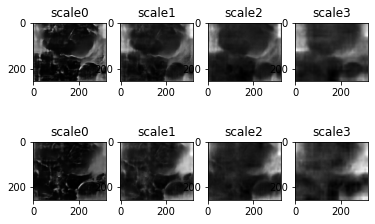

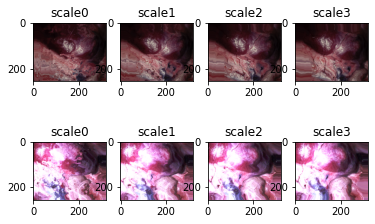

In [9]:
os.chdir('/content')
args = get_args()

train_loader = DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset_valid, batch_size=args.valid_batch_size, shuffle=False, num_workers=2)
inputs = next(iter(valid_loader))#(3 items) [Tensor with shape torch.Size([18, 3, 256, 320])
images_cat = torch.cat(inputs[:2], 1).to(device)#([18, 6, 256, 320]
left, right = inputs[0].to(device), inputs[1].to(device)

outputs = depth_decoder(depth_encoder(left))#print(pred.keys())#[('disp', 3), ('disp', 2), ('disp', 1), ('disp', 0)] # [18, 1, 32, 40],[18, 1, 64, 80][18, 1, 128, 160][18, 1, 256, 320]
disps_l = [outputs[('disp', i)] for i in range(args.n)]
outputs = depth_decoder(depth_encoder(right))#print(pred.keys())#[('disp', 3), ('disp', 2), ('disp', 1), ('disp', 0)] # [18, 1, 32, 40],[18, 1, 64, 80][18, 1, 128, 160][18, 1, 256, 320]
disps_r = [outputs[('disp', i)] for i in range(args.n)]

feat = [pose_encoder(images_cat)] # [torch.Size([18, 64, 128, 160]),torch.Size([18, 64, 64, 80]),torch.Size([18, 128, 32, 40]),torch.Size([18, 256, 16, 20]),torch.Size([18, 512, 8, 10]]
axisangle, translation = pose_decoder(feat)#[18, 2, 1, 3]
mat_T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=False)#[18, 4, 4]
inv_mat_T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=True)

# reprojection loss: D, inv_K, T, K
loss_photo_geo = Loss()
depthmaps_l = loss_photo_geo.disp_to_depth(disps_l)
depthmaps_r = loss_photo_geo.disp_to_depth(disps_r)
K = transforms.ToTensor()(np.array(args.K)).repeat(args.batch_size, 1, 1).float().to(device) #[18, 4, 4]#.to(device)
inv_K = transforms.ToTensor()(np.linalg.pinv(args.K)).repeat(args.batch_size, 1, 1).float()[:, :3, :3].to(device) #[18, 4, 4]
backprojection = BackProjection(args.batch_size, args.input_height, args.input_width)# 
warped_l, warped_r = [], []
for i in range(args.n):
    pcl_l = backprojection(inv_K, depthmaps_l[i])
    grid_l = projection(pcl_l, K, mat_T, args.batch_size, args.input_height, args.input_width)
    warped_l.append(F.grid_sample(right, grid_l, padding_mode="border"))# input：[B, C, H_in, W_in]# grid: [B, H_out, W_out, 2]# output: [B, C, H_out, W_out]
    pcl_r = backprojection(inv_K, depthmaps_r[i])
    grid_r = projection(pcl_r, K, inv_mat_T, args.batch_size, args.input_height, args.input_width)
    warped_r.append(F.grid_sample(left, grid_r, padding_mode="border"))# input：[B, C, H_in, W_in]# grid: [B, H_out, W_out, 2]# output: [B, C, H_out, W_out]
l1_l = [torch.mean(torch.abs(warped_r[i] - left)) for i in range(args.n)]# if not upsampled depth, then create pyramid_l[i]
l1_r = [torch.mean(torch.abs(warped_l[i] - right)) for i in range(args.n)]#pyramid_r[i]
ssim_l =  [torch.mean(loss_photo_geo.ssim(warped_r[i], left)) for i in range(args.n)]#pyramid_l[i]
ssim_r =  [torch.mean(loss_photo_geo.ssim(warped_l[i], right)) for i in range(args.n)]#pyramid_r[i]
reprojection_loss_l = [0.85 * ssim_l[i] + 0.15 * l1_l[i]for i in range(args.n)]
reprojection_loss_r = [0.85 * ssim_r[i] + 0.15 * l1_r[i]for i in range(args.n)]
reprojection_loss = sum(reprojection_loss_l + reprojection_loss_r)

# disparity smoothness loss
pyramid_l = loss_photo_geo.scale_pyramid(left, args.n)
pyramid_r = loss_photo_geo.scale_pyramid(right, args.n)
smooth_l = loss_photo_geo.disp_smoothness(disps_l, pyramid_l)
smooth_r = loss_photo_geo.disp_smoothness(disps_r, pyramid_r)
disp_left_loss = [torch.mean(torch.abs( smooth_l[i])) / 2 ** i for i in range(args.n)]
disp_right_loss = [torch.mean(torch.abs(smooth_r[i])) / 2 ** i for i in range(args.n)]
disp_gradient_loss = sum(disp_left_loss + disp_right_loss)
loss =  disp_gradient_loss + reprojection_loss

# ICP loss
icp = loss_photo_geo.compute_ICP_loss_no_MASK(pcl_l, pcl_r)

# plot
id = 3
for i in range(4):
    plt.subplot(241+i),plt.imshow(depthmaps_l[i][id].squeeze().detach().cpu().numpy(), cmap='gray'),plt.title('scale'+str(i))
    plt.subplot(245+i),plt.imshow(depthmaps_r[i][id].squeeze().detach().cpu().numpy(), cmap='gray'),plt.title('scale'+str(i))
plt.show()
for i in range(4):
    plt.subplot(241+i),plt.imshow(warped_l[i][id].permute(1,2,0).detach().cpu().numpy()),plt.title('scale'+str(i))
    plt.subplot(245+i),plt.imshow(warped_r[i][id].permute(1,2,0).detach().cpu().numpy()),plt.title('scale'+str(i))
plt.show()



In [10]:
def train(optimizer, models, loader, criterion, args):
    # if args.adjust_lr:
    #     adjust_learning_rate(optimizer, epoch, args.learning_rate)
    
    train_losses = []
    for model in models:
        model.train()

    for data in loader:
        images_cat = torch.cat(data[:2], 1).to(device)#([18, 6, 256, 320]
        left, right = data[0].to(device), data[1].to(device)
        # process batch
        outputs = depth_decoder(depth_encoder(left))#print(pred.keys())#[('disp', 3), ('disp', 2), ('disp', 1), ('disp', 0)] # [18, 1, 32, 40],[18, 1, 64, 80][18, 1, 128, 160][18, 1, 256, 320]
        disps_l = [outputs[('disp', i)] for i in range(args.n)]
        outputs = depth_decoder(depth_encoder(right))#print(pred.keys())#[('disp', 3), ('disp', 2), ('disp', 1), ('disp', 0)] # [18, 1, 32, 40],[18, 1, 64, 80][18, 1, 128, 160][18, 1, 256, 320]
        disps_r = [outputs[('disp', i)] for i in range(args.n)]

        feat = [pose_encoder(images_cat)] # [torch.Size([18, 64, 128, 160]),torch.Size([18, 64, 64, 80]),torch.Size([18, 128, 32, 40]),torch.Size([18, 256, 16, 20]),torch.Size([18, 512, 8, 10]]
        axisangle, translation = pose_decoder(feat)#[18, 2, 1, 3]
        mat_T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=False)#[18, 4, 4]
        inv_mat_T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=True)
        # 
        depthmaps_l = criterion.disp_to_depth(disps_l)
        depthmaps_r = criterion.disp_to_depth(disps_r)
        K = transforms.ToTensor()(np.array(args.K)).repeat(args.batch_size, 1, 1).float().to(device) #[18, 4, 4]#.to(device)
        inv_K = transforms.ToTensor()(np.linalg.pinv(args.K)).repeat(args.batch_size, 1, 1).float()[:, :3, :3].to(device) #[18, 4, 4]
        backprojection = BackProjection(args.batch_size, args.input_height, args.input_width)# 
        warped_l, warped_r = [], []
        for i in range(args.n):
            pcl_l = backprojection(inv_K, depthmaps_l[i])
            grid_l = projection(pcl_l, K, mat_T, args.batch_size, args.input_height, args.input_width)
            warped_l.append(F.grid_sample(right, grid_l, padding_mode="border"))# input：[B, C, H_in, W_in]# grid: [B, H_out, W_out, 2]# output: [B, C, H_out, W_out]
            pcl_r = backprojection(inv_K, depthmaps_r[i])
            grid_r = projection(pcl_r, K, inv_mat_T, args.batch_size, args.input_height, args.input_width)
            warped_r.append(F.grid_sample(left, grid_r, padding_mode="border"))# input：[B, C, H_in, W_in]# grid: [B, H_out, W_out, 2]# output: [B, C, H_out, W_out]
        l1_l = [torch.mean(torch.abs(warped_r[i] - left)) for i in range(args.n)]# if not upsampled depth, then create pyramid_l[i]
        l1_r = [torch.mean(torch.abs(warped_l[i] - right)) for i in range(args.n)]#pyramid_r[i]
        ssim_l =  [torch.mean(loss_photo_geo.ssim(warped_r[i], left)) for i in range(args.n)]#pyramid_l[i]
        ssim_r =  [torch.mean(loss_photo_geo.ssim(warped_l[i], right)) for i in range(args.n)]#pyramid_r[i]
        reprojection_loss_l = [0.85 * ssim_l[i] + 0.15 * l1_l[i]for i in range(args.n)]
        reprojection_loss_r = [0.85 * ssim_r[i] + 0.15 * l1_r[i]for i in range(args.n)]
        reprojection_loss = sum(reprojection_loss_l + reprojection_loss_r)

        # disparity smoothness loss
        pyramid_l = criterion.scale_pyramid(left, args.n)
        pyramid_r = criterion.scale_pyramid(right, args.n)
        smooth_l = criterion.disp_smoothness(disps_l, pyramid_l)
        smooth_r = criterion.disp_smoothness(disps_r, pyramid_r)
        disp_left_loss = [torch.mean(torch.abs( smooth_l[i])) / 2 ** i for i in range(args.n)]
        disp_right_loss = [torch.mean(torch.abs(smooth_r[i])) / 2 ** i for i in range(args.n)]
        disp_gradient_loss = sum(disp_left_loss + disp_right_loss)
        
        # ICP loss
        icp_loss = criterion.compute_ICP_loss_no_MASK(pcl_l, pcl_r)

        loss =  disp_gradient_loss + reprojection_loss + icp_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return np.mean(train_losses)

def val(models, val_loader, criterion, applyICP, ICPweight):
    for model in models:
        model.eval()

    val_losses = []
    with torch.no_grad():
        for data in val_loader:
            images_cat = torch.cat(data[:2], 1).to(device)#([18, 6, 256, 320]
            left, right = data[0].to(device), data[1].to(device)
            # process batch
            outputs = depth_decoder(depth_encoder(left))#print(pred.keys())#[('disp', 3), ('disp', 2), ('disp', 1), ('disp', 0)] # [18, 1, 32, 40],[18, 1, 64, 80][18, 1, 128, 160][18, 1, 256, 320]
            disps_l = [outputs[('disp', i)] for i in range(args.n)]
            outputs = depth_decoder(depth_encoder(right))#print(pred.keys())#[('disp', 3), ('disp', 2), ('disp', 1), ('disp', 0)] # [18, 1, 32, 40],[18, 1, 64, 80][18, 1, 128, 160][18, 1, 256, 320]
            disps_r = [outputs[('disp', i)] for i in range(args.n)]

            feat = [pose_encoder(images_cat)] # [torch.Size([18, 64, 128, 160]),torch.Size([18, 64, 64, 80]),torch.Size([18, 128, 32, 40]),torch.Size([18, 256, 16, 20]),torch.Size([18, 512, 8, 10]]
            axisangle, translation = pose_decoder(feat)#[18, 2, 1, 3]
            mat_T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=False)#[18, 4, 4]
            inv_mat_T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=True)
            # 
            depthmaps_l = criterion.disp_to_depth(disps_l)
            depthmaps_r = criterion.disp_to_depth(disps_r)
            K = transforms.ToTensor()(np.array(args.K)).repeat(args.batch_size, 1, 1).float().to(device) #[18, 4, 4]#.to(device)
            inv_K = transforms.ToTensor()(np.linalg.pinv(args.K)).repeat(args.batch_size, 1, 1).float()[:, :3, :3].to(device) #[18, 4, 4]
            backprojection = BackProjection(args.batch_size, args.input_height, args.input_width)# 
            warped_l, warped_r = [], []
            for i in range(args.n):
                pcl_l = backprojection(inv_K, depthmaps_l[i])
                grid_l = projection(pcl_l, K, mat_T, args.batch_size, args.input_height, args.input_width)
                warped_l.append(F.grid_sample(right, grid_l, padding_mode="border"))# input：[B, C, H_in, W_in]# grid: [B, H_out, W_out, 2]# output: [B, C, H_out, W_out]
                pcl_r = backprojection(inv_K, depthmaps_r[i])
                grid_r = projection(pcl_r, K, inv_mat_T, args.batch_size, args.input_height, args.input_width)
                warped_r.append(F.grid_sample(left, grid_r, padding_mode="border"))# input：[B, C, H_in, W_in]# grid: [B, H_out, W_out, 2]# output: [B, C, H_out, W_out]
            l1_l = [torch.mean(torch.abs(warped_r[i] - left)) for i in range(args.n)]# if not upsampled depth, then create pyramid_l[i]
            l1_r = [torch.mean(torch.abs(warped_l[i] - right)) for i in range(args.n)]#pyramid_r[i]
            ssim_l =  [torch.mean(loss_photo_geo.ssim(warped_r[i], left)) for i in range(args.n)]#pyramid_l[i]
            ssim_r =  [torch.mean(loss_photo_geo.ssim(warped_l[i], right)) for i in range(args.n)]#pyramid_r[i]
            reprojection_loss_l = [0.85 * ssim_l[i] + 0.15 * l1_l[i]for i in range(args.n)]
            reprojection_loss_r = [0.85 * ssim_r[i] + 0.15 * l1_r[i]for i in range(args.n)]
            reprojection_loss = sum(reprojection_loss_l + reprojection_loss_r)

            # disparity smoothness loss
            pyramid_l = criterion.scale_pyramid(left, args.n)
            pyramid_r = criterion.scale_pyramid(right, args.n)
            smooth_l = criterion.disp_smoothness(disps_l, pyramid_l)
            smooth_r = criterion.disp_smoothness(disps_r, pyramid_r)
            disp_left_loss = [torch.mean(torch.abs( smooth_l[i])) / 2 ** i for i in range(args.n)]
            disp_right_loss = [torch.mean(torch.abs(smooth_r[i])) / 2 ** i for i in range(args.n)]
            disp_gradient_loss = sum(disp_left_loss + disp_right_loss)
            
            # ICP loss
            icp_loss = criterion.compute_ICP_loss_no_MASK(pcl_l, pcl_r)

            loss =  disp_gradient_loss + reprojection_loss + icp_loss
            val_losses.append(loss.item())
    return np.mean(val_losses)


In [11]:
if not os.path.exists('/content/weights/'):
    !mkdir /content/weights

In [12]:
import time
import torch.optim as optim
os.chdir('/content')
if not os.path.exists('/content/weights/'):
    !mkdir content/weights

def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed_everything()
    args = get_args()
    print("Sample size- Train:%d, Valid: %d"%(len(dataset_train), len(dataset_valid)))
    train_loader = DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(dataset_valid, batch_size=args.valid_batch_size, shuffle=False, num_workers=2)
    # depth_encoder.to(device)
    # pose_encoder.to(device)
    # depth_decoder.to(device)
    # pose_decoder.to(device)
    models = []
    models.append(depth_encoder)
    models.append(depth_decoder)
    models.append(pose_encoder)
    models.append(pose_decoder)

    parameters = []
    for model in models:
        model.to(device)
        parameters += list(model.parameters())

    criterion = Loss()
        
    optimizer = optim.Adam(parameters, lr=args.lr)

    icpLosses, running_val_loss, best_val_loss= 0, 0, np.inf
    running_val_loss = val(models, valid_loader, criterion, applyICP=args.applyICP, ICPweight=args.ICPweight)# running_val_loss /= self.val_n_img / self.args.batch_size
    print('Val_loss:', running_val_loss)
    
    for epoch in range(args.startEpoch, args.max_epochs):
        start = time.time()
        running_train_loss = train(optimizer, models, valid_loader, criterion, args)
        running_val_loss = val(models, valid_loader, criterion, applyICP=False, ICPweight=args.ICPweight)
     
        print( 'Epoch:',epoch + 1,'train_loss:',running_train_loss,'val_loss:',running_val_loss,'time:',round(time.time() - start, 3),'s',)

        torch.save(models[0].state_dict(), 'weights/depth_encoder_border_last.pth')
        torch.save(models[2].state_dict(), 'weights/pose_encoder_border_last.pth')
        torch.save(models[1].state_dict(), 'weights/decoder_border_last.pth')
        torch.save(models[3].state_dict(), 'weights/pose_decoder_border_last.pth')
        torch.save(models[0].state_dict(), 'weights/depth_encoder_epoch{}.pth'.format(str(epoch)) )
        torch.save(models[2].state_dict(), 'weights/pose_encoder_epoch{}.pth'.format(str(epoch)) )
        torch.save(models[1].state_dict(), 'weights/depth_decoder_epoch{}.pth'.format(str(epoch)) )
        torch.save(models[3].state_dict(), 'weights/pose_decoder_epoch{}.pth'.format(str(epoch)) )
        torch.save({'epoch': epoch,
                    'encoder_model_state_dict': models[0].state_dict(),
                    'decoder_model_state_dict': models[1].state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': running_train_loss,
                    }, os.path.join('weights', 'weights_last.pt'))

        if running_val_loss < best_val_loss:
            torch.save(models[0].state_dict(), 'weights/depth_encoder_border_cpt.pth')
            torch.save(models[2].state_dict(), 'weights/pose_encoder_border_cpt.pth')
            torch.save(models[1].state_dict(), 'weights/depth_decoder_border_cpt.pth')
            torch.save(models[3].state_dict(), 'weights/pose_decoder_border_cpt.pth')
            # torch.save_continue_train(epoch, running_val_loss, 'weights_cpt.pt')
            best_val_loss = running_val_loss
            print('Model_saved')

    print('Finished Training.')
    # torch.save(os.path.join(models[0].state_dict(), 'weights', 'train_end.pth'))
    torch.save({'epoch': args.max_epochs,
                'lr': args.lr,
                    'encoder_model_state_dict': models[0].state_dict(),
                    'pose_encoder_model_state_dict': models[2].state_dict(),
                    'decoder_model_state_dict': models[1].state_dict(),
                    'pose_decoder_model_state_dict': models[3].state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': running_val_loss,
                    }, os.path.join('weights', 'train_end.pt'))
if __name__ == "__main__":
    main()

Sample size- Train:76, Valid: 20
Val_loss: 2.181489682197571
Epoch: 1 train_loss: 2.084430694580078 val_loss: 2.0390048265457152 time: 24.746 s
Model_saved
Epoch: 2 train_loss: 2.066009044647217 val_loss: 1.9231555700302123 time: 23.335 s
Model_saved
Epoch: 3 train_loss: 1.9554370880126952 val_loss: 2.004511904716492 time: 18.719 s
Epoch: 4 train_loss: 1.8321259260177611 val_loss: 1.7587006568908692 time: 18.276 s
Model_saved
Epoch: 5 train_loss: 1.7922735214233398 val_loss: 1.7197455644607544 time: 18.487 s
Model_saved
Epoch: 6 train_loss: 1.7342154264450074 val_loss: 1.82033109664917 time: 18.426 s
Epoch: 7 train_loss: 1.7208909273147583 val_loss: 1.5953793048858642 time: 18.258 s
Model_saved
Epoch: 8 train_loss: 1.5538480520248412 val_loss: 1.6213201522827148 time: 16.795 s
Epoch: 9 train_loss: 1.3910778999328612 val_loss: 1.4071150064468383 time: 17.249 s
Model_saved
Epoch: 10 train_loss: 1.1872756004333496 val_loss: 1.3374822854995727 time: 18.837 s
Model_saved
Epoch: 11 train_los

# test dataset (with 70 gt depth map)

In [ ]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2
import gdown
import os

url = 'https://drive.google.com/uc?id=1LX26iq2qBjvxnbRicXPXidNKclWtQJ2E'
gdown.download(url,'SCARED.zip',quiet=True) 
if not os.path.exists('/content/SCARED/'):
  !unzip -q SCARED.zip 
     

os.chdir('/content')
class TestDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform

    def __len__(self):
      return len(self.path_depth)   

    def __getitem__(self, i):
        depth = tifffile.imread(self.path_depth[i])[:,:,2]
        depth = Image.fromarray(depth).convert('L')
        path_ = self.path_depth[i]
        path_ = path_.replace('left', 'Left')
        path_ = path_.replace('right', 'Right')
        img = Image.open(path_[:-14] + 'Image.png').convert('RGB')
        if self.transform:
            img, depth = self.transform(img), depth#self.transform(depth)
        return img, depth

#(1024, 1280, 3)
transform_test = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),    
])

path_test = glob('SCARED/*.tiff')
print('all:', len(path_test))


In [ ]:
def test(self):
    self.model.eval()

    ''' train on full endovis and test on Endovis test dataset keyframe'''

    errors = []
    transform_resize = transforms.Resize((256, 320))
    with torch.no_grad():
        # disps = self.model(left_input_image)
        # disps_upsample = F.interpolate(disps[0][:, 0, :, :].unsqueeze(1), [self.args.full_height, self.args.full_width], mode="bilinear",align_corners=False).squeeze().cpu().detach().numpy()
        # depth_pred = (baseline * focal) / (disps_upsample * 1280)
        errors.append(compute_errors(depth_gt_left, depth_pred))
        mean_errors = np.array(errors).mean(0)

    #### 7 criteria ####
    print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
    print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
    print("\n-> Done!")

In [16]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2
import torch.nn as nn
import torch
import torch.nn.functional as F
from pytorch3d.ops import iterative_closest_point
# from pytorch3d.loss import chamfer_distance

# for data in test_loader:
#     img, dep = data[0], data[1]
#     scaled_images = [img]
#     batch_size, _, h, w = img.size()
#     K = np.array([[1.18849248e+03, 0.00000000e+00, 6.41449814e+02, 0.00000000e+00], # [[1.03530811e+03 0.00000000e+00 5.96955017e+02]
#                   [0.00000000e+00, 1.18849248e+03, 5.20022934e+02, 0.00000000e+00],#  [0.00000000e+00 1.03508765e+03 5.20410034e+02]
#                   [0, 0, 1, 0],
#                   [0, 0, 0, 1]], dtype=np.float32)
#     inv_K = transforms.ToTensor()(np.linalg.pinv(K))#[1, 4, 4]
#     inv_K = inv_K.repeat(batch_size, 1, 1)#[10, 4, 4]
#     for i in range(3):
#       ratio = 2**(i+1)
#       scaled_images.append(nn.functional.interpolate(img, size=[h//ratio, w//ratio], mode='bilinear', align_corners=True))
#     # def apply_disparity_for_ICP(self, img, disp): 
#     x_base_ICP = torch.linspace(0, 1, w).repeat(batch_size, h, 1).type_as(img) #[10, 256, 320]
#     y_base_ICP = torch.linspace(0, 1, h).repeat(batch_size, w, 1).transpose(1, 2).type_as(img) #[10, 256, 320]
#     x_shifts_ICP = dep.squeeze(1)
#     flow_field_ICP = torch.stack((x_base_ICP + x_shifts_ICP, y_base_ICP), dim=3)
#     reconstruct_left = F.grid_sample(img, 2 * flow_field_ICP - 1, mode='bilinear', padding_mode='zeros')
#     left_mask = [(torch.where(reconstruct_left[:, 0, :, :] == 0, torch.tensor(0), torch.tensor(1))).unsqueeze(1)]#reconstruct_left[0][:, 0, :, :] unscaled size
#     # left_mask = F.interpolate(left_mask[0].float(), [imgHeight, imgWidth], mode="bilinear", align_corners=False)# 1024 1280
    
#     plt.subplot(131), plt.imshow(img[9,:,:,:].permute(1,2,0))
#     plt.subplot(132), plt.imshow(reconstruct_left[9,:,:,:].permute(1,2,0))
#     plt.subplot(133), plt.imshow(left_mask[0][9,0,:,:], cmap='gray')#list of one tensor item[10, 1, 256, 320]
#     plt.show()
    
#     #def depth_to_pcl(self, depth, inv_K, applyMask, mask=None):
#     meshgrid = np.meshgrid(range(w), range(h), indexing='xy')
#     id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
#     id_coords = nn.Parameter(torch.from_numpy(id_coords), requires_grad=False)
#     ones = nn.Parameter(torch.ones(batch_size, 1, h * w), requires_grad=False)
#     pix_coords = torch.unsqueeze(torch.stack([id_coords[0].view(-1), id_coords[1].view(-1)], 0), 0)
#     pix_coords = pix_coords.repeat(batch_size, 1, 1)
#     pix_coords = nn.Parameter(torch.cat([pix_coords, ones], 1), requires_grad=False)
#     cam_points = torch.matmul(inv_K[:, :3, :3], pix_coords)#[10,3,3] [10, 3, 81920]
#     cam_points = depth.view(batch_size, 1, -1) * cam_points
#     cam_points = torch.cat([cam_points, ones], 1)
#     pclLeft = cam_points
    
#     #def compute_ICP_loss_with_MASK(self, pclLeft, pclRight):
#     batchsize = pclLeft.shape[0]
#     PCL_L = torch.zeros(batchsize, 3, 1000)
#     PCL_R = torch.zeros(batchsize, 3, 1000)

#     for item in range(batchsize):
#         single_Left = pclLeft[item]
#         filtered_pclLeft = single_Left[:3, single_Left[2, :] > 0]
#         single_Right = pclRight[item]
#         filtered_pclRight = single_Right[:3, single_Right[2, :] > 0]
#         index = torch.randint(0, min(filtered_pclLeft.shape[1], filtered_pclRight.shape[1]), (1000,)).cuda()

#         pcl_l = torch.index_select(filtered_pclLeft, 1, index)
#         pcl_r = torch.index_select(filtered_pclRight, 1, index)
#         PCL_L[item, :, :] = pcl_l
#         PCL_R[item, : ,:] = pcl_r

#         _, icploss, _, _, _ = iterative_closest_point(PCL_L.permute(0, 2, 1), PCL_R.permute(0, 2, 1))  # the second from last is RTs

        # icploss = icploss.mean().to(pclLeft.device)
    # def compute_ICP_loss(self, pclLeft, pclRight):
    #     indexL = torch.randint(0, 1310720, (20000,)).cuda()
    #     indexR = torch.randint(0, 1310720, (20000,)).cuda()
    #     icploss , _ = chamfer_distance(torch.index_select(pclLeft.permute(0, 2, 1)[:, :, :3], 1, indexL),
    #                                    torch.index_select(pclRight.permute(0, 2, 1)[:, :, :3], 1, indexR))
    #     return icploss

all: 0


# inference of 3 models

In [26]:
!pip -q install transformers
from transformers import DPTFeatureExtractor, DPTForDepthEstimation

feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 78.0 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# os.chdir('/content')
# !pip -q install einops
# if not os.path.isdir('M3Depth'):
#     !git clone https://github.com/br0202/M3Depth.git
# %cd M3Depth
# from loss import MonodepthLoss#, ICPLoss
# from models_resnet import Resnet18_md

# m3depth_model = Resnet18_md(3)


dict_keys(['loss', 'predicted_depth', 'hidden_states', 'attentions'])


(<matplotlib.axes._subplots.AxesSubplot at 0x7f46d5e336a0>,
 <matplotlib.image.AxesImage at 0x7f46d5df50a0>)

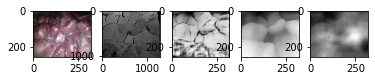

In [38]:
# inference

import matplotlib.pyplot as plt

os.chdir('/content')
dataset_test = TestDataset(path_depth=path_test, transform=transform_test)
plt.subplot(251), plt.imshow(dataset_test[0][0].permute(1,2,0))
plt.subplot(252), plt.imshow(dataset_test[0][1], cmap='gray')


# monodepth2
gdown.download('https://drive.google.com/uc?id=1LS3CeNv4YeyPYUCc_bax5Ewm_ctS1Lka', "encoder_ssim.pth", quiet=True)
gdown.download('https://drive.google.com/uc?id=1NcNFlVQZKFmHdMkQUUggIJbauRuMKwmd', 'decoder_ssim.pth', quiet=True)
depth_encoder.load_state_dict(torch.load("/content/encoder_ssim.pth", map_location=device))
depth_decoder.load_state_dict(torch.load("/content/decoder_ssim.pth", map_location=device))
feat = depth_encoder(dataset_test[0][0][None].to(device))
pred = depth_decoder(feat)
plt.subplot(253), plt.imshow(pred[('disp',0)][0][0].detach().cpu(), cmap='gray')

#DPT
image_raw = transforms.ToPILImage()(dataset_test[0][0])#[None]
image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
encoding = feature_extractor(image, return_tensors="pt")
with torch.no_grad():
    outputs = depth_estimation(**encoding)
    print(outputs.__dict__.keys())#['loss', 'predicted_depth', 'hidden_states', 'attentions']
    predicted_depth = outputs.predicted_depth
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image_raw.size[::-1],
    mode="bicubic",
    align_corners=False,
).squeeze()
output = prediction.cpu().numpy() 
plt.subplot(254), plt.imshow(output, cmap='gray')

#M3Depth
# disps = m3depth_model(dataset_train[0][0][None])
# plt.subplot(254), plt.imshow(disps[0][0,0,:,:].detach().cpu(), cmap='gray')#[1, 2, 256, 320]
# plt.subplot(259), plt.imshow(disps[0][0,1,:,:].detach().cpu(), cmap='gray')
# disps = m3depth_model(dataset_train[0][1][None])
# plt.subplot(255), plt.imshow(disps[0][0,0,:,:].detach().cpu(), cmap='gray')#[1, 2, 256, 320]
# plt.subplot(2,5,10), plt.imshow(disps[0][0,1,:,:].detach().cpu(), cmap='gray')

# monodepth2
os.chdir('/content')

depth_encoder.load_state_dict(torch.load("/content/weights/depth_encoder_border_cpt.pth", map_location=device))
depth_decoder.load_state_dict(torch.load("/content/weights/depth_decoder_border_cpt.pth", map_location=device))
feat = depth_encoder(dataset_test[0][0][None].to(device))
outputs = depth_decoder(feat)
plt.subplot(255), plt.imshow(outputs[('disp',0)][0][0].detach().cpu(), cmap='gray')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f46d5d66460>,
 <matplotlib.image.AxesImage at 0x7f46d5d3a3a0>)

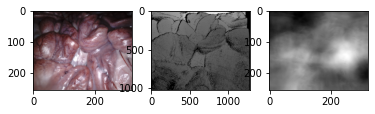

In [39]:
depth_encoder.load_state_dict(torch.load("/content/weights/depth_encoder_border_cpt.pth", map_location=device))
depth_decoder.load_state_dict(torch.load("/content/weights/depth_decoder_border_cpt.pth", map_location=device))
feat = depth_encoder(dataset_test[0][0][None].to(device))
outputs = depth_decoder(feat)

plt.subplot(131), plt.imshow(dataset_test[0][0].permute(1,2,0))
plt.subplot(132), plt.imshow(dataset_test[0][1], cmap='gray')
plt.subplot(133), plt.imshow(outputs[('disp',0)][0][0].detach().cpu(), cmap='gray')

# 3D reconstruction

In [ ]:
# rgbd
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(np.array(image_raw))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    image_o3d, depth_o3d, convert_rgb_to_intensity=False)

# intrinsic
h = int(depth_image.shape[0])
w = int(depth_image.shape[1])
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
# camera_intrinsic.set_intrinsics(w, h, 500, 500, w/2, h/2)#500, 500, 640,512
camera_intrinsic.set_intrinsics(w, h, 1035, 1035, 597, 520)#1035, 1035, 597,520
print('intrinsic:\n', camera_intrinsic.intrinsic_matrix)

# rgbd intrin pcd
# invalidate existing normals
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
pcd.normals = o3d.utility.Vector3dVector(np.zeros((1, 3)))  
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
pcd.orient_normals_towards_camera_location(camera_location=np.array([0., 0., 1000.]))
pcd.transform([[1, 0, 0, 0],
                [0, -1, 0, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1]])
pcd.transform([[-1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]]) 

# run Poisson surface reconstruction
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh_raw, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=10, width=0, scale=1.1, linear_fit=True)

voxel_size = max(mesh_raw.get_max_bound() - mesh_raw.get_min_bound()) / 256
print(f'voxel_size = {voxel_size:e}')
mesh = mesh_raw.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)

# vertices_to_remove = densities < np.quantile(densities, 0.001)
# mesh.remove_vertices_by_mask(vertices_to_remove)
bbox = pcd.get_axis_aligned_bounding_box() 
mesh_crop = mesh.crop(bbox)
gltf_path = f'./{img_path}.gltf'
o3d.io.write_triangle_mesh(gltf_path, mesh_crop, write_triangle_uvs=True)

# vid2depth main

# C3VD

<p float="left">
<img src='https://durr.jhu.edu/wp-content/uploads/2022/06/2022-C3VD_ex.png' height=150>
</p>

In [ ]:
import gdown
import os

gdown.download("https://drive.google.com/uc?export=view&id=1nn4t7vPaZb5iKxg9UqoAG0lQXE1Co66e&confirm=t", 'cecum_t1_a.zip', quiet=True)
if not os.path.isdir('c1v1'):
    !unzip -q cecum_t1_a

In [ ]:
gdown.download("http://drive.google.com/uc?export=view&id=1EsWdG3r9WYUpONzNKFbNVl_u9zpTQPCd", 'ascend_colon.obj', quiet=True)

gdown.download("http://drive.google.com/uc?export=view&id=1ZYpT3aXKlpcW4kr_Qfa7dT9S_OPrMPPQ", 'cecum_t1_a_mold.zip', quiet=True)
if not os.path.isdir('/content/ascend_mold_under_review'):
    !unzip cecum_t1_a_mold.zip
top = "/content/ascend_mold_under_review/ascend_mold_top.stl"
core = top.replace('top', 'core')
core = top.replace('top', 'bottom')

In [ ]:
gdown.download("http://drive.google.com/uc?export=view&id=18m3Z5zJtljor_AGmPW8OgO9fRuactuNk&confirm=t", 'full_colon_t1.zip', quiet=True)
if not os.path.isdir('/content/seq1'):
    !unzip -q full_colon_t1.zip

In [ ]:
import torch
import sys

# We try to install PyTorch3D via a released wheel.
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip -q install fvcore iopath
!pip -q install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html


In [ ]:
from glob import glob

path_obj = glob('c1v1/*.obj')#ground truth triangulated mesh
print(path_obj, len(path_obj))#'c1v1/outputMesh.obj'

In [ ]:
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
import os

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
trg_obj = os.path.join('c1v1/outputMesh.obj')
verts, faces, aux = load_obj(trg_obj)
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# center = verts.mean(0)
# verts = verts - center
# scale = max(verts.abs().max(0)[0])
# verts = verts / scale

trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [ ]:
from pytorch3d.ops import sample_points_from_meshes
import matplotlib.pyplot as plt

def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    ax = plt.figure(figsize=(5, 5)).add_subplot(projection='3d')
    # ax = Axes3D(fig)
    ax.scatter3D(x, z, -y, cmap='gray')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

plot_pointcloud(trg_mesh, "Target mesh")




In [ ]:
from tqdm import tqdm

deform_verts = torch.full(trg_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))


In [ ]:
from PIL import Image
import numpy as np
# import tifffile
import gdal

color = Image.open('/content/c1v1/1_color.png')
depth = gdal.Open('/content/c1v1/1_depth.tiff').ReadAsArray()# (1080, 1350)
normals = gdal.Open('/content/c1v1/1_normals.tiff').ReadAsArray().transpose(1,2,0)# (3, 1080, 1350)
flow = gdal.Open('/content/c1v1/1_flow.tiff').ReadAsArray().transpose(1,2,0)# (3, 1080, 1350)
print(flow.max())
flow = Image.fromarray((flow*255).astype(np.uint8))
occlusion = Image.open('/content/c1v1/1_occlusion.png').convert('RGB')
plt.subplot(251), plt.imshow(color)
plt.subplot(252), plt.imshow(depth)
plt.subplot(253), plt.imshow(normals)
plt.subplot(254), plt.imshow(flow)
plt.subplot(255), plt.imshow(occlusion)

In [ ]:
from glob import glob
from google.colab import files
import matplotlib.pyplot as plt

path_txt = glob('c1v1/*.txt')# homogenous pose (flattened in row-major order)
print(path_txt, len(path_txt))#'c1v1/pose.txt'
# files.download('seq1/pose.txt')

with open('c1v1/pose.txt') as f:
    lines = f.readlines()#list of 276 items
poses_list = []
for line in lines:
    a = line.strip().split(',')
    pose = np.array(line.strip().split(',')).reshape(4,4).astype(float)# Strips the newline character
    poses_list.append(pose)
poses_arr = np.array(poses_list)
print(poses_arr.shape)
print(poses_arr[275], np.linalg.det(poses_list[275][:2,:2]))

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_zlabel("z (mm)")
ax.scatter(poses_arr[0, 0, 3], poses_arr[0, 1, 3], zs=poses_arr[0, 2, 3], c='r', label='starting location') #, zdir='y'
ax.scatter(poses_arr[50, 0, 3], poses_arr[50, 1, 3], zs=poses_arr[50, 2, 3], c='y', label='50th frame location') #, zdir='y'
ax.scatter(0, 0, zs=0, c='g', label='origin', marker='X') #, zdir='y'
figure1, = ax.plot(poses_arr[:, 0, 3], poses_arr[:, 1, 3], poses_arr[:, 2, 3], c='k', label='cecum t1 a GT')#, zdir='z'
# figure2, = ax.plot(pred_points[:, 0, 0], pred_points[:, 1, 0], pred_points[:, 2, 0], c='b', label=index2+' GT')
ax.legend()
plt.savefig('poses.png')
plt.show()

In [ ]:
path_tiff = glob('c1v1/*_depth.tiff')
print(len(path_tiff))

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.
# https://gitea.auro.re/otthorn/nerf_tutorial/src/commit/f948b8e7e82e6009dc0801ecd5cb607bd913c7b3/utils/camera_visualization.py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from pytorch3d.vis.plotly_vis import get_camera_wireframe


def plot_cameras(ax, cameras, color: str = "blue"):
    """
    Plots a set of `cameras` objects into the maplotlib axis `ax` with
    color `color`.
    """
    cam_wires_canonical = get_camera_wireframe().cuda()[None]
    cam_trans = cameras.get_world_to_view_transform().inverse()
    cam_wires_trans = cam_trans.transform_points(cam_wires_canonical)
    plot_handles = []
    for wire in cam_wires_trans:
        # the Z and Y axes are flipped intentionally here!
        x_, z_, y_ = wire.detach().cpu().numpy().T.astype(float)
        (h,) = ax.plot(x_, y_, z_, color=color, linewidth=0.3)
        plot_handles.append(h)
    return plot_handles


def plot_camera_scene(cameras, cameras_gt, status: str):
    """
    Plots a set of predicted cameras `cameras` and their corresponding
    ground truth locations `cameras_gt`. The plot is named with
    a string passed inside the `status` argument.
    """
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.clear()
    ax.set_title(status)
    handle_cam = plot_cameras(ax, cameras, color="#FF7D1E")
    handle_cam_gt = plot_cameras(ax, cameras_gt, color="#812CE5")
    plot_radius = 3
    ax.set_xlim3d([-plot_radius, plot_radius])
    ax.set_ylim3d([3 - plot_radius, 3 + plot_radius])
    ax.set_zlim3d([-plot_radius, plot_radius])
    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_zlabel("y")
    labels_handles = {
        "Estimated cameras": handle_cam[0],
        "GT cameras": handle_cam_gt[0],
    }
    ax.legend(
        labels_handles.values(),
        labels_handles.keys(),
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
    )
    plt.show()
    return fig